In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import numpy as np
import scipy as sp
import json
import ast
import torch
import ase.io as aseio
torch.set_default_dtype(torch.float64)
device="cpu"

from rascaline import SphericalExpansion, SphericalExpansionByPair
from equistore import Labels, TensorBlock, TensorMap
from equistore import operations

from tqdm.notebook import tqdm
from utils.builder import TensorBuilder
import ase.io
from itertools import product
from utils.mp_utils import acdc_standardize_keys, cg_increment, cg_combine, _remove_suffix, flatten
from utils.clebsh_gordan import ClebschGordanReal
from utils.hamiltonians import hamiltonian_features
import matplotlib.pyplot as plt

import copy
from utils.model_hamiltonian import *
from itertools import product
import tqdm.notebook as tqdm
import chemiscope

In [3]:
from generate_bispectrum_structures import generate_nu3_degen_structs

# Generates a bunch of degenerate pairs - closer or farther from being actually symmetric

### Random Boron clusters

In [4]:
np.random.seed(12345)
ngen = 1000
frames = []
for f in tqdm.tqdm(range(ngen)):
    for i in range(1000):
        r = np.random.uniform(0.5,2)
        z1 = np.random.uniform(0.5,2)
        z2 = np.random.uniform(1.5,1.8)
        psi = np.random.uniform(0,np.pi)
        phi1 = np.random.uniform(np.pi/6, np.pi)
        phi2 = np.random.uniform(np.pi/6, np.pi)
        fr = generate_nu3_degen_structs(r, [0, phi1, phi1+phi2], 
                                   psi, z1, z2, "B", "B", "B")
        dist = fr[0].get_all_distances()
        if dist[0,1:].min()>1.5 and dist[0,1:].max()<1.8 and np.abs(dist-1.0).flatten().min()>0.5:
            fr[0].info["pars"] = str((f, "+")+(r, z1, z2, psi, phi1, phi2))
            fr[1].info["pars"] = str((f, "-")+(r, z1, z2, psi, phi1, phi2))
            break
    if (i>990):
        print("oops!")
    frames += fr

In [5]:
cs = chemiscope.show(frames=frames, mode="structure", settings = {'structure': [{
   'axes': 'xyz',
   'keepOrientation': True,
   'playbackDelay': 250}]})
display(cs)

StructureWidget(value='{"meta": {"name": " "}, "settings": {"structure": [{"axes": "xyz", "keepOrientation": t…

/home/michele/local/lib/python3.8/site-packages/chemiscope/input.py:195: UserWarning: chemiscope behavior changed to no longer include properties from the structure objects. Use `chemiscope.extract_properties` to also visualize these properties ([pars])
  warnings.warn(


In [25]:
frames[134*2].info["pars"]

"(134, '+', 1.2313367121339533, 1.07392163993562, 1.6947503705446838, 0.9633078988888877, 1.993842337599831, 1.6583212922073822)"

In [7]:
aseio.write("/tmp/b8.xyz", frames)

### Mg clusters

In [9]:
frames_mg = []
n1, n2, n3 = 8,8,8
for psi in np.linspace(np.pi/6, np.pi*5/6, n1):
    for dphi1 in np.linspace(np.pi*2/3 - 1.2, np.pi*2/3+0.4, n2):
        for dphi2 in np.linspace(np.pi*2/3-0.7, np.pi*2/3+1.3, n3):
            frames_mg += generate_nu3_degen_structs(2, [0, dphi1, dphi1+dphi2], 
                           psi, 1, np.sqrt(5), "Mg", "Mg", "Mg")

In [10]:
# shuffles keeping pairs together for easier analysis
idx = np.asarray(range(len(frames_mg)//2), dtype=int)
np.random.shuffle(idx)
nfr = []
for i in idx:
    nfr.append(frames_mg[2*i])
    nfr.append(frames_mg[2*i+1])
frames_mg = nfr

In [58]:
cs = chemiscope.show(frames=frames_mg, mode="structure", settings = {'structure': [{
   'axes': 'xyz',
   'keepOrientation': True,
   'playbackDelay': 250}]})
display(cs)

StructureWidget(value='{"meta": {"name": " "}, "settings": {"structure": [{"axes": "xyz", "keepOrientation": t…

In [66]:
aseio.write("/tmp/mg8.xyz", frames_mg)

# Loads pre-computed clusters

In [4]:
frames = aseio.read("data/three_center/boron/boron8_4000_pbeccpvdz.xyz", ":1000")

In [5]:
# explicit name for manifold parameters, and baseline for energy
e0 = -198.11364281310415
for fi, f in enumerate(frames):
    f.info["energy_rel_eV"] = (f.info["energy_ha"]-e0)*27.211386
    for n, v in zip( ("index", "label","r", "z_1", "z_2", "psi", "phi_1", "phi_2"), ast.literal_eval(f.info["pars"]) ):
        f.info[n] = v
    if fi%2 ==1:
        frames[fi].info["delta"] = np.abs(frames[fi].info["energy_rel_eV"]-frames[fi-1].info["energy_rel_eV"])
        frames[fi-1].info["delta"] = frames[fi].info["delta"]

In [6]:
cs = chemiscope.show(frames=frames, properties=chemiscope.extract_properties(frames), settings = {'structure': [{
   'axes': 'xyz',
   'keepOrientation': True,
   'playbackDelay': 250}]})
display(cs)

ChemiscopeWidget(value='{"meta": {"name": " "}, "settings": {"structure": [{"axes": "xyz", "keepOrientation": …

# Compute raw expansion coefficients

In [7]:
hypers = {
    "cutoff": 2.5,
    "max_radial": 2,
    "max_angular": 3,
    "atomic_gaussian_width": 0.2,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    "center_atom_weight": 0.0,    
}
calculator = SphericalExpansion(**hypers)
rhoi = calculator.compute(frames)
rhoi = rhoi.keys_to_properties(['species_neighbor'])
rho1i = acdc_standardize_keys(rhoi)

# selects only one environment
rho1i = operations.slice(rho1i, samples=Labels(['center'],np.array([[0]], np.int32)) )
norm_rho1 = np.sqrt(np.sum([(b.values**2).sum(axis=(1,2)) for b in rho1i.blocks()],axis=0).mean())
for b in rho1i.blocks():
    b.values[:]/=norm_rho1

In [8]:
rho1i

TensorMap with 4 blocks
keys: ['order_nu' 'inversion_sigma' 'spherical_harmonics_l' 'species_center']
           1             1                    0                   5
           1             1                    1                   5
           1             1                    2                   5
           1             1                    3                   5

In [9]:
rho1i.block(0)

TensorBlock
    samples (1000): ['structure', 'center']
    components (1): ['spherical_harmonics_m']
    properties (2): ['species_neighbor_1', 'n_1']
    gradients: no

In [10]:
calculator = SphericalExpansionByPair(**hypers)
gij = calculator.compute(frames)
gij = operations.slice(gij, samples=Labels(['first_atom'],np.array([[0]], np.int32)) )
gij =  acdc_standardize_keys(gij)
for b in gij.blocks():
    b.values[:]/=norm_rho1

In [11]:
gij

TensorMap with 4 blocks
keys: ['order_nu' 'inversion_sigma' 'spherical_harmonics_l' 'species_center' 'species_neighbor']
           1             1                    0                   5                5
           1             1                    1                   5                5
           1             1                    2                   5                5
           1             1                    3                   5                5

In [12]:
gij.block(0)

TensorBlock
    samples (8000): ['structure', 'center', 'neighbor']
    components (1): ['spherical_harmonics_m']
    properties (2): ['n_1']
    gradients: no

## Test there is consistency at the level of rhoij and gij

In [13]:
test = operations.sum_over_samples(gij, samples_names=["neighbor"]) 

In [14]:
test.block(1).values;

In [15]:
np.linalg.norm(rho1i.block(1).values/test.block(1).values -1)

7.568891221116074e-13

# Now compute the correlation stuff!

In [16]:
cg = ClebschGordanReal(5)

## pair features

In [17]:
%%time
rhoii1i2_nu0 = cg_combine(gij, gij, clebsch_gordan=cg, other_keys_match=['species_center'], lcut=3)

CPU times: user 6.52 s, sys: 208 ms, total: 6.73 s
Wall time: 6.72 s


In [18]:
%%time 
rhoii1i2_nu1 =  cg_combine(rho1i, rhoii1i2_nu0, clebsch_gordan=cg, other_keys_match = ['species_center'], lcut=0)

CPU times: user 5.38 s, sys: 116 ms, total: 5.49 s
Wall time: 5.49 s


### sanity checks

In [19]:
# nb: we disable lexicographic sorting of L to have comparable feature layout
rho2i_full = cg_combine(rho1i, rho1i, clebsch_gordan=cg, lcut=3, sorted_l=False)
test = operations.sum_over_samples(rhoii1i2_nu0, samples_names=["neighbor_1", "neighbor_2"]) 

In [20]:
np.linalg.norm(rho2i_full.block(2).values/test.block(2).values-1)

2.395485600100662e-10

## higher-order 

In [21]:
%%time
# here we use all tricks to reduce cost
rho2i = cg_increment(rho1i, rho1i, clebsch_gordan=cg, lcut=3)
rho3i = cg_increment(rho2i, rho1i, clebsch_gordan=cg, lcut=3)
rho4i = cg_increment(rho3i, rho1i, clebsch_gordan=cg, lcut=3)
rho5i = cg_increment(rho4i, rho1i, clebsch_gordan=cg, lcut=0)

CPU times: user 5.78 s, sys: 375 ms, total: 6.15 s
Wall time: 6.15 s


In [22]:
%%time 
#rho5il1 = cg_increment(rho4i, rho1i, clebsch_gordan=cg, lcut=1)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [23]:
%time 
#rho6il1 = cg_increment(rho5il1, rho1i, clebsch_gordan=cg, lcut=1)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [24]:
%time 
#rho7i = cg_increment(rho6il1, rho1i, clebsch_gordan=cg, lcut=0, filter_sigma=[1])

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 14.1 µs


## PCA

Since we have a LOT of features and few structures, we use PCA to reduce the number of features with no information loss

In [25]:
from sklearn.decomposition import PCA

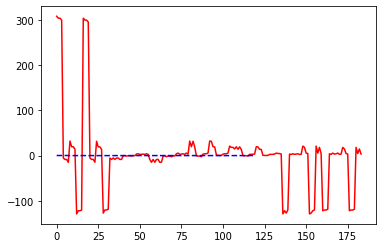

In [26]:
plt.plot(rhoii1i2_nu1.block(0).values.squeeze()[:64].sum(axis=0)*2e3,'r-')
plt.plot(rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze()[0], 'b--')

In [27]:
raw = np.hstack([rhoii1i2_nu1.block(0).values.squeeze(),rhoii1i2_nu1.block(1).values.squeeze()])
feats_n2nu1 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw)/ np.sqrt((raw**2).sum(axis=1).mean()), device=device)

In [28]:
triplet_samples = rhoii1i2_nu1.block(0).samples

In [29]:
raw = np.hstack([
    rho1i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho2i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=-1,spherical_harmonics_l=0).values.squeeze()
])
feats_nu123 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw) / np.sqrt((raw**2).sum(axis=1).mean()),device=device)

In [30]:
raw = np.hstack([
    rho1i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho2i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho4i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho5i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=-1,spherical_harmonics_l=0).values.squeeze(),
    rho4i.block(inversion_sigma=-1,spherical_harmonics_l=0).values.squeeze(),
    rho5i.block(inversion_sigma=-1,spherical_harmonics_l=0).values.squeeze()
])
feats_nu12345 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw) / np.sqrt((raw**2).sum(axis=1).mean()),device=device)

38


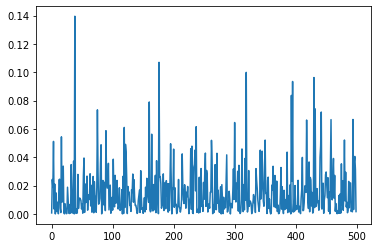

In [31]:
deltas = np.sqrt(((feats_nu12345[::2]-feats_nu12345[1::2])**2).sum(axis=1).cpu().numpy())/np.sqrt(((feats_nu12345[::2]+feats_nu12345[1::2])**2).sum(axis=1).cpu().numpy())
plt.plot(deltas )
print(deltas.argmax())

In [32]:
cs = chemiscope.show(frames=frames, properties = { 
 "feats12345":    feats_nu12345[:,:8].cpu().numpy(),
 "type" : [i%2 for i in range(len(frames))],
 "deltas" : [deltas[i//2]   for i in range(len(frames)) ],
 "pars" : [f.info["pars"] for f in frames]   
}
                     , settings = {
                         'map': {'x': {'max': 0.8114175656679125,
   'min': -0.32173653263255847,
   'property': 'feats12345[1]',
   'scale': 'linear'},
  'y': {'max': 0.5533810292695732,
   'min': -0.29561319677262154,
   'property': 'feats12345[2]',
   'scale': 'linear'},
  'color': {'max': 0.15750915598126383,
   'min': 8.705512017627933e-08,
   'property': 'deltas',
   'scale': 'log'},
  'symbol': '',
  'palette': 'inferno',
  'size': {'factor': 50, 'mode': 'linear', 'property': '', 'reverse': False}},                         
                         'structure': [{
   'axes': 'xyz',
   'keepOrientation': True,
   'playbackDelay': 250}]})
display(cs)

ChemiscopeWidget(value='{"meta": {"name": " "}, "settings": {"map": {"x": {"max": 0.8114175656679125, "min": -…

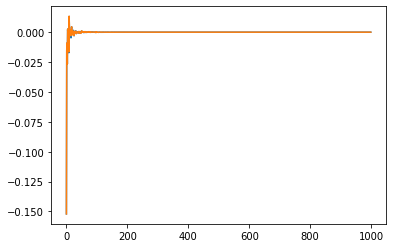

In [33]:
plt.plot(feats_nu12345[14].cpu().numpy())
plt.plot(feats_nu12345[15].cpu().numpy())

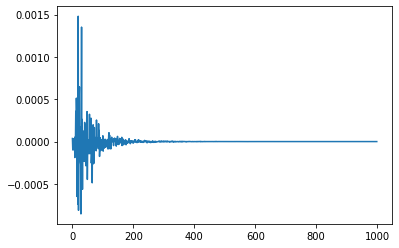

In [34]:
plt.plot((feats_nu12345[220]-feats_nu12345[221]).cpu().numpy())

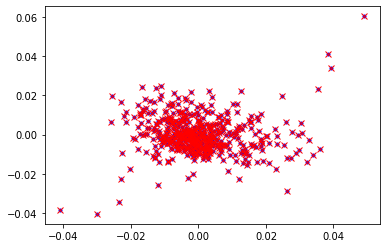

In [35]:
plt.plot(feats_nu123[::2,7].cpu().numpy(), feats_nu123[::2,8].cpu().numpy(), 'b.')
plt.plot(feats_nu123[1::2,7].cpu().numpy(), feats_nu123[1::2,8].cpu().numpy(), 'rx')

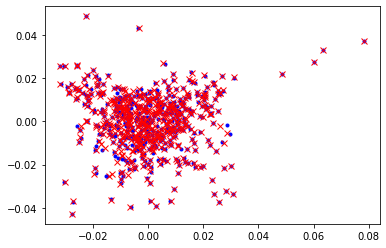

In [36]:
plt.plot(feats_nu12345[::2,8].cpu().numpy(), feats_nu12345[::2,9].cpu().numpy(), 'b.')
plt.plot(feats_nu12345[1::2,8].cpu().numpy(), feats_nu12345[1::2,9].cpu().numpy(), 'rx')

# Now we make an autoencoder thingie

In [37]:
def StructureMap(samples_structure, device="cpu"):
    unique_structures, unique_structures_idx = np.unique(
        samples_structure, return_index=True
    )
    new_samples = samples_structure[np.sort(unique_structures_idx)]
    # we need a list keeping track of where each atomic contribution goes
    # (e.g. if structure ids are [3,3,3,1,1,1,6,6,6] that will be stored as
    # the unique structures [3, 1, 6], structure_map will be
    # [0,0,0,1,1,1,2,2,2]
    replace_rule = dict(zip(unique_structures, range(len(unique_structures))))
    structure_map = torch.tensor(
        [replace_rule[i] for i in samples_structure],
        dtype=torch.long,
        device=device,
    )
    return structure_map, new_samples, replace_rule

In [38]:
class LinearEncodeDecode(torch.nn.Module):
    def __init__(self, layer_size=100, feat_size=32, output_size=32):
        super().__init__()

        self.nn_encode = None
        self.nn_decode = None
        self.layer_size = layer_size 
        self.feat_size = feat_size
        self.output_size= output_size        

    def initialize_model_weights(self, block, seed):
        if seed is not None:
            torch.manual_seed(seed)

        X = block

        # initialize nn with zero weights ??
        def init_zero_weights(m):
            if isinstance(m, torch.nn.Linear):
                m.weight.data.fill_(0)
                m.bias.data.fill_(0)

        self.nn_encode = torch.nn.Sequential(
            torch.nn.Linear(X.shape[-1], self.feat_size))
        self.nn_decode = torch.nn.Sequential(
            torch.nn.Linear(self.feat_size, self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.output_size),            
        )
    
    def feats(self, block, samples):
        tensor = block

        structure_map, new_samples, _ = StructureMap(
            samples, next(self.parameters()).device
        )
        
        nn_per_triple = self.nn_encode(tensor)
        nn_per_structure = torch.zeros((len(new_samples), nn_per_triple.shape[-1]), device=tensor.device)
        nn_per_structure.index_add_(0, structure_map, nn_per_triple)
        return nn_per_structure
        
    def forward(self, block, samples):
        if self.nn_encode is None:
            raise Exception("call initialize_weights first")

        outputs = self.nn_decode(self.feats(block, samples))
        return outputs

In [156]:
class EncodeDecode(torch.nn.Module):
    def __init__(self, layer_size=100, feat_size=32, output_size=32):
        super().__init__()

        self.nn_encode = None
        self.nn_decode = None
        self.feat_size = feat_size
        self.layer_size = layer_size        
        self.output_size= output_size        

    def initialize_model_weights(self, block, seed):
        if seed is not None:
            torch.manual_seed(seed)

        X = block

        # initialize nn with zero weights ??
        def init_zero_weights(m):
            if isinstance(m, torch.nn.Linear):
                m.weight.data.fill_(0)
                m.bias.data.fill_(0)

        self.nn_encode = torch.nn.Sequential(            
            torch.nn.Linear(X.shape[-1], self.layer_size),
            torch.nn.GroupNorm(8,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.layer_size),
            torch.nn.GroupNorm(8,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.feat_size))
        self.nn_decode = torch.nn.Sequential(
            torch.nn.Linear(self.feat_size, self.layer_size),
            torch.nn.GroupNorm(8,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.layer_size),
            torch.nn.GroupNorm(8,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.output_size),            
        )

    def feats(self, block, samples):
        tensor = block

        structure_map, new_samples, _ = StructureMap(
            samples, next(self.parameters()).device
        )
        
        nn_per_triple = self.nn_encode(tensor)
        nn_per_structure = torch.zeros((len(new_samples), nn_per_triple.shape[-1]), device=tensor.device)
        nn_per_structure.index_add_(0, structure_map, nn_per_triple)
        return nn_per_structure
        
    def forward(self, block, samples):
        if self.nn_encode is None:
            raise Exception("call initialize_weights first")

        outputs = self.nn_decode(self.feats(block, samples))
        return outputs

In [157]:
feats_nu12345.shape

torch.Size([1000, 1000])

In [158]:
energy = torch.tensor([f.info["energy_rel_eV"] for f in frames], device=device)

In [159]:
target = feats_nu12345[:,:128]

In [160]:
mymodel = LinearEncodeDecode(64, 32, target.shape[-1])

In [161]:
mymodel = EncodeDecode(64, 32, target.shape[-1])

In [185]:
mymodel.initialize_model_weights(feats_n2nu1, seed=12345)
mymodel.to(device=device)

EncodeDecode(
  (nn_encode): Sequential(
    (0): Linear(in_features=272, out_features=64, bias=True)
    (1): GroupNorm(8, 64, eps=1e-05, affine=True)
    (2): Tanh()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): GroupNorm(8, 64, eps=1e-05, affine=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=32, bias=True)
  )
  (nn_decode): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): GroupNorm(8, 64, eps=1e-05, affine=True)
    (2): Tanh()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): GroupNorm(8, 64, eps=1e-05, affine=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=128, bias=True)
  )
)

In [163]:
def loss_mse(predicted, actual):
    return torch.sum((predicted.flatten() - actual.flatten()) ** 2)

## Run optimization

In [356]:
optimizer = torch.optim.Adam(
        mymodel.parameters(),
        lr=0.0001
    )

In [357]:
n_epochs = 20000
ntrain = 512
ntriples = 64
for epoch in range(0, n_epochs):
    
    optimizer.zero_grad()
    predicted = mymodel(feats_n2nu1[:ntrain*ntriples], triplet_samples["structure"][:ntrain*ntriples])
    loss = loss_mse(predicted, target[:ntrain])
    loss.backward(retain_graph=False)
    optimizer.step()
    
    
    if epoch % 10 ==0:
        predicted = mymodel(feats_n2nu1[ntrain*ntriples:], triplet_samples["structure"][ntrain*ntriples:])
        print("Epoch:", epoch, "Energy RMSE: train ", np.sqrt(loss.detach().cpu().numpy().flatten()[0]/ntrain),
         "test", np.sqrt(loss_mse(predicted, target[ntrain:]).detach().cpu().numpy().flatten()[0]/ (len(frames)-ntrain)) )

Epoch: 0 Energy RMSE: train  0.002970187451467943 test 0.4833048103378391
Epoch: 10 Energy RMSE: train  0.1550615960779777 test 0.07547343969761607
Epoch: 20 Energy RMSE: train  0.12718926249294019 test 0.08168989726490244
Epoch: 30 Energy RMSE: train  0.0847933728252939 test 0.0684287995299091
Epoch: 40 Energy RMSE: train  0.05161633513069691 test 0.045276471308378974
Epoch: 50 Energy RMSE: train  0.03151979102909992 test 0.0260616989828825
Epoch: 60 Energy RMSE: train  0.01844258843584674 test 0.014080599345526672
Epoch: 70 Energy RMSE: train  0.009441131031462331 test 0.010515278002868845
Epoch: 80 Energy RMSE: train  0.00795043927547955 test 0.009762546721983135
Epoch: 90 Energy RMSE: train  0.006258749523857914 test 0.007541559869002435
Epoch: 100 Energy RMSE: train  0.005270976415420453 test 0.0071784744286250285
Epoch: 110 Energy RMSE: train  0.0047012417766214495 test 0.006691297324298953
Epoch: 120 Energy RMSE: train  0.004396704053571026 test 0.006497447657357946
Epoch: 130 E

KeyboardInterrupt: 

In [358]:
optimizer = torch.optim.LBFGS(
        mymodel.parameters(),
        lr=0.1,
        line_search_fn="strong_wolfe",
        history_size=128,
    )

In [ ]:
n_epochs = 10000
ntrain = 512
ntriples = 64
for epoch in range(0, n_epochs):
    
    def single_step():
        # global composition, radial_spectrum, spherical_expansions, energies
        optimizer.zero_grad()
        loss = torch.zeros(size=(1,), device=device)
        
        predicted = mymodel(feats_n2nu1[:ntrain*ntriples], triplet_samples["structure"][:ntrain*ntriples])
        loss += loss_mse(predicted, target[:ntrain])
        
        loss.backward(retain_graph=False)
        return loss

    loss = optimizer.step(single_step)
        
    if epoch % 10 ==0:
        predicted = mymodel(feats_n2nu1[ntrain*ntriples:], triplet_samples["structure"][ntrain*ntriples:])
        print("Epoch:", epoch, "Energy RMSE: train ", np.sqrt(loss.detach().cpu().numpy().flatten()[0]/ntrain),
         "test", np.sqrt(loss_mse(predicted, target[ntrain:]).detach().cpu().numpy().flatten()[0]/ (len(frames)-ntrain)) )

Epoch: 0 Energy RMSE: train  0.003971330826720149 test 0.006127631381555737
Epoch: 10 Energy RMSE: train  0.003120597137739991 test 0.005690331928765675
Epoch: 20 Energy RMSE: train  0.0030485008638914757 test 0.0056531821507382575
Epoch: 30 Energy RMSE: train  0.003017551056080821 test 0.00562654899392857
Epoch: 40 Energy RMSE: train  0.003003460646237032 test 0.005617183280870448
Epoch: 50 Energy RMSE: train  0.0029940857728056602 test 0.005611705289003766
Epoch: 60 Energy RMSE: train  0.0029882178016705807 test 0.005611419290716971
Epoch: 70 Energy RMSE: train  0.002984219126712703 test 0.005610379835700302
Epoch: 80 Energy RMSE: train  0.0029815199319829133 test 0.005606853241485137
Epoch: 90 Energy RMSE: train  0.0029790740030901553 test 0.0056045828814356045
Epoch: 100 Energy RMSE: train  0.002977240852751829 test 0.005601962980396256
Epoch: 110 Energy RMSE: train  0.002975812886018577 test 0.005598947454620593
Epoch: 120 Energy RMSE: train  0.0029744598105393423 test 0.005596673

In [320]:
%%time 
predicted = mymodel(feats_n2nu1, triplet_samples["structure"])
feats = mymodel.feats(feats_n2nu1, triplet_samples["structure"])

CPU times: user 1.03 s, sys: 3.99 ms, total: 1.04 s
Wall time: 188 ms


In [321]:
np.linalg.norm((predicted[:ntrain]-target[:ntrain]).cpu().detach() )/(
    np.linalg.norm(target[:ntrain].cpu()) )

0.012944152749368791

In [322]:
np.linalg.norm((((predicted[:ntrain:2]+predicted[1:ntrain:2])/2) - ((target[:ntrain:2]+target[1:ntrain:2])/2)).cpu().detach() )/(
    np.linalg.norm(target[:ntrain].cpu()) )

0.008192263882922412

In [323]:
np.linalg.norm((((predicted[ntrain::2]+predicted[ntrain+1::2])/2) - ((target[ntrain::2]+target[ntrain+1::2])/2)).cpu().detach() ) / (
    np.linalg.norm(target[:ntrain].cpu()) )

0.0162733799970069

In [324]:
np.linalg.norm((((predicted[:ntrain:2]-predicted[1:ntrain:2])) - ((target[:ntrain:2]-target[1:ntrain:2]))).cpu().detach() )/ (
    np.linalg.norm((target[:ntrain:2]-target[1:ntrain:2]).cpu()))

0.3371901263224485

In [325]:
np.linalg.norm((((predicted[ntrain::2]-predicted[1+ntrain::2])) - 
                ((target[ntrain::2]-target[ntrain+1::2]))).cpu().detach() )/ (
    np.linalg.norm((target[ntrain::2]-target[1+ntrain::2]).cpu()))

0.3726797384883636

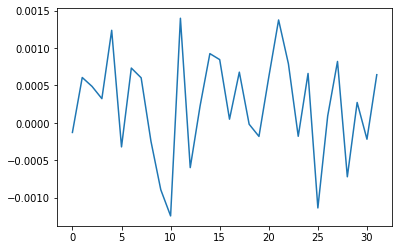

In [326]:
plt.plot(feats[30].cpu().detach()-feats[31].cpu().detach())

tensor(3)


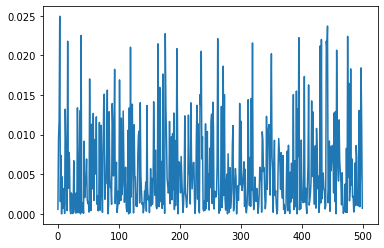

In [327]:
plt.plot(np.sqrt(((target[::2]-target[1::2])**2).sum(axis=1)))
print(np.sqrt(((target[::2]-target[1::2])**2).sum(axis=1)).argmax())

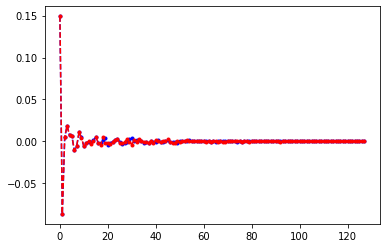

In [328]:
iframe = 72
plt.plot(predicted[iframe].detach(),'b--')
plt.plot(target[iframe].detach(),'b.')
plt.plot(predicted[iframe+1].detach(), 'r--')
plt.plot(target[iframe+1].detach(), 'r.')

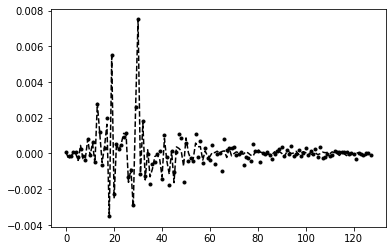

In [329]:
plt.plot((predicted[iframe].detach()-predicted[iframe+1].detach()),'k--')
plt.plot(target[iframe].detach()-target[iframe+1].detach(), 'k.')

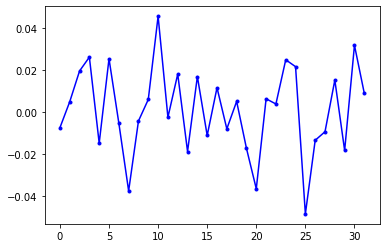

In [330]:
plt.plot((feats[iframe].detach()-feats[iframe+1].detach()),'b.-')

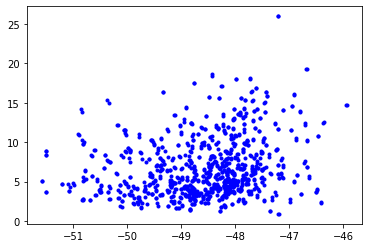

In [331]:
plt.plot(feats[:,8].detach(), energy.detach(),'b.')

# Now use learned features to predict energy

In [333]:
layer_size=80
energy_model = torch.nn.Sequential(            
            torch.nn.Linear(feats.shape[-1], layer_size),
            torch.nn.GroupNorm(4,layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(layer_size, layer_size),
            torch.nn.GroupNorm(4,layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(layer_size, 1))

In [334]:
energy_model.to(device=device)

Sequential(
  (0): Linear(in_features=32, out_features=80, bias=True)
  (1): GroupNorm(4, 80, eps=1e-05, affine=True)
  (2): Tanh()
  (3): Linear(in_features=80, out_features=80, bias=True)
  (4): GroupNorm(4, 80, eps=1e-05, affine=True)
  (5): Tanh()
  (6): Linear(in_features=80, out_features=1, bias=True)
)

In [335]:
energy_feats = feats.clone().detach()

In [340]:
energy_optimizer = torch.optim.Adam(
        energy_model.parameters(),
        lr=0.01)

In [341]:
n_epochs = 10000
ntrain = 900
for epoch in range(0, n_epochs):
    
    energy_optimizer.zero_grad()
    loss = torch.zeros(size=(1,), device=device)

    predicted = energy_model(energy_feats[:ntrain])
    loss += loss_mse(predicted, energy[:ntrain])

    loss.backward(retain_graph=False)
    energy_optimizer.step()
    
    if epoch % 100 ==0:
        predicted = energy_model(energy_feats[ntrain:])
    
        print("Epoch:", epoch, "Energy RMSE: train ", np.sqrt(loss.detach().cpu().numpy().flatten()[0]/ntrain),
         "test", np.sqrt(loss_mse(predicted, energy[ntrain:]).detach().cpu().numpy().flatten()[0]/ (len(frames)-ntrain)) )

Epoch: 0 Energy RMSE: train  1.5091059971798781 test 72.27808759135479
Epoch: 100 Energy RMSE: train  4.293835983781176 test 4.880613241434874
Epoch: 200 Energy RMSE: train  3.669952887871419 test 4.1124404402341
Epoch: 300 Energy RMSE: train  3.2467230389452677 test 3.562984343817739
Epoch: 400 Energy RMSE: train  2.837517017343233 test 2.9964559372199417
Epoch: 500 Energy RMSE: train  2.546734482256547 test 2.557106133983207
Epoch: 600 Energy RMSE: train  2.3527759297651567 test 2.3500367143675875
Epoch: 700 Energy RMSE: train  2.276592510796698 test 2.339532442634689
Epoch: 800 Energy RMSE: train  2.241425167764877 test 2.3320043063867315
Epoch: 900 Energy RMSE: train  2.2193447109016455 test 2.343620652242463
Epoch: 1000 Energy RMSE: train  2.1625850406072726 test 2.2687416288734505
Epoch: 1100 Energy RMSE: train  2.1135979100424005 test 2.217083815102259
Epoch: 1200 Energy RMSE: train  2.054711895886908 test 2.153461419435069
Epoch: 1300 Energy RMSE: train  1.9913296935260207 test

In [342]:
energy_optimizer = torch.optim.LBFGS(
        energy_model.parameters(),
        lr=0.1,
        line_search_fn="strong_wolfe",
        history_size=128
    )

In [343]:
n_epochs = 10000
ntrain = 900
for epoch in range(0, n_epochs):
    def energy_step():
        # global composition, radial_spectrum, spherical_expansions, energies
        energy_optimizer.zero_grad()
        loss = torch.zeros(size=(1,), device=device)
        
        predicted = energy_model(energy_feats[:ntrain])
        loss += loss_mse(predicted, energy[:ntrain])
        
        loss.backward(retain_graph=False)
        return loss

    loss = energy_optimizer.step(energy_step)
    
    if epoch % 10 ==0:
        predicted = energy_model(energy_feats[ntrain:])
    
        print("Epoch:", epoch, "Energy RMSE: train ", np.sqrt(loss.detach().cpu().numpy().flatten()[0]/ntrain),
         "test", np.sqrt(loss_mse(predicted, energy[ntrain:]).detach().cpu().numpy().flatten()[0]/ (len(frames)-ntrain)) )

Epoch: 0 Energy RMSE: train  1.514971980058805 test 1.6979447557524165
Epoch: 10 Energy RMSE: train  1.4937535298585591 test 1.669210508838766
Epoch: 20 Energy RMSE: train  1.4858585070617516 test 1.703962532071665
Epoch: 30 Energy RMSE: train  1.4782047268261471 test 1.743266303837384
Epoch: 40 Energy RMSE: train  1.4594773687826295 test 1.8392438128856756
Epoch: 50 Energy RMSE: train  1.4488922881464754 test 2.066915252736314
Epoch: 60 Energy RMSE: train  1.4362278790674026 test 2.0425950091041183
Epoch: 70 Energy RMSE: train  1.4184506741343514 test 2.5576987190652507
Epoch: 80 Energy RMSE: train  1.3990374016493186 test 3.1315000273523115
Epoch: 90 Energy RMSE: train  1.385860260930606 test 3.3417216191719143
Epoch: 100 Energy RMSE: train  1.3690448661664056 test 3.212419979522556
Epoch: 110 Energy RMSE: train  1.3447235734847145 test 3.5833970945018065
Epoch: 120 Energy RMSE: train  1.3295659131772264 test 4.38982305406787
Epoch: 130 Energy RMSE: train  1.3178065630134947 test 5.1

In [344]:
predicted = energy_model(energy_feats)

In [345]:
predicted[10]

tensor([9.0645], grad_fn=<SelectBackward0>)

In [346]:
predicted[11]

tensor([8.8161], grad_fn=<SelectBackward0>)

In [347]:
energy[10], energy[11]

(tensor(9.1295), tensor(9.0060))

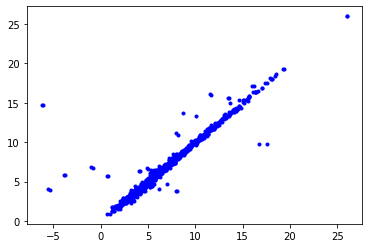

In [348]:
plt.plot(predicted.cpu().detach(), energy.cpu(),'b.')

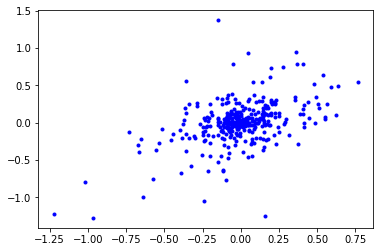

In [350]:
plt.plot((predicted[::2]-predicted[1::2]).cpu().detach()[:ntrain//2], (energy[::2]-energy[1::2]).cpu()[:ntrain//2],'b.')